# SPINN (series) visualizations

In [ ]:
from setproctitle import setproctitle
setproctitle("SPINN (viz)")

In [ ]:
import os 
import time
import glob
import numpy as np 
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path

from cmspinn.mag_viz import mag_plotter

In [ ]:
spinn_output_path = os.path.expanduser('~/workspace/_data/NOAA12673/SPINN')

vmin = -3000
vmax = 3000

i_siz = 160
j_siz = 100

i_res = 15
j_res = 15

In [ ]:
b_bottom_paths = os.path.expanduser('~/workspace/_data/NOAA12673/b_bottom')
vtk_output_path = os.path.join(Path(b_bottom_paths).parent, 'SPINN_vtk')
os.makedirs(vtk_output_path, exist_ok=True)

In [ ]:
b_potential_path = os.path.expanduser('~/workspace/_data/NOAA12673/b_potential')

## loss

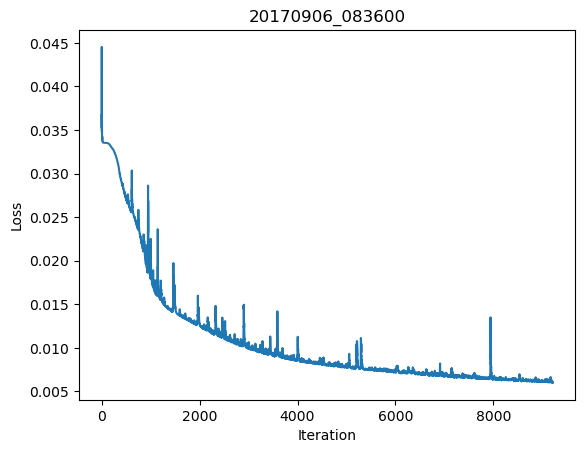

In [ ]:
b_bottom_path_list = sorted(glob.glob(os.path.join(b_bottom_paths, '*.npy')))

fig, ax = plt.subplots()

def update(frame_number):
    ax.cla()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    
    b_bottom_path = b_bottom_path_list[frame_number]
    b_bottom_date = os.path.basename(b_bottom_path)[9:-4]

    target_path = os.path.join(spinn_output_path, b_bottom_date)
    loss_path = os.path.join(target_path, 'losses.npy')

    with open(loss_path, "rb") as f:
        losses = np.load(f)

    ax.plot(losses)
    ax.set_title(b_bottom_date)

ani = animation.FuncAnimation(fig, update, frames=len(b_bottom_path_list))
HTML(ani.to_html5_video())

## vtk viz

In [ ]:
pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend('static')

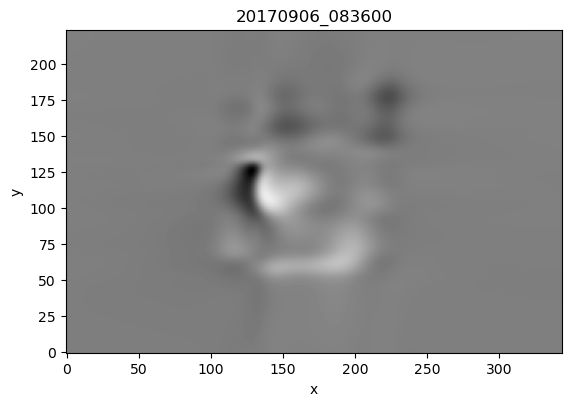

In [ ]:
b_bottom_path_list = sorted(glob.glob(os.path.join(b_bottom_paths, '*.npy')))

fig, ax = plt.subplots()

def update(frame_number):
    ax.cla()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    b_bottom_path = b_bottom_path_list[frame_number]
    b_bottom_date = os.path.basename(b_bottom_path)[9:-4]

    B_spinn_vtk_path = os.path.join(vtk_output_path, f'B_spinn_{b_bottom_date}.vtk')
    B_spinn_mesh = pv.read(B_spinn_vtk_path)
    B_spinn = mag_plotter(B_spinn_mesh)

    ax.imshow(B_spinn.B[:, :, 0, 2].transpose(), origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_title(b_bottom_date)

ani = animation.FuncAnimation(fig, update, frames=len(b_bottom_path_list))
HTML(ani.to_html5_video())

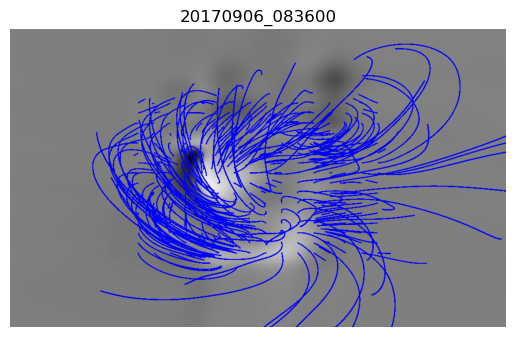

In [ ]:
b_bottom_path_list = sorted(glob.glob(os.path.join(b_bottom_paths, '*.npy')))

fig, ax = plt.subplots()

def update(frame_number):
    ax.cla()
    ax.axis('off')
    
    b_bottom_path = b_bottom_path_list[frame_number]
    b_bottom_date = os.path.basename(b_bottom_path)[9:-4]

    B_spinn_vtk_path = os.path.join(vtk_output_path, f'B_spinn_{b_bottom_date}.vtk')
    B_spinn_mesh = pv.read(B_spinn_vtk_path)
    B_spinn = mag_plotter(B_spinn_mesh)
    B_spinn.create_mesh(i_siz=i_siz, j_siz=j_siz, 
                   i_resolution=i_res, j_resolution=j_res,
                   vmin=vmin, vmax=vmax)

    p = pv.Plotter(off_screen=True)
    p.add_mesh(B_spinn.grid.outline())
    p.add_mesh(B_spinn.bottom, cmap='gray', show_scalar_bar=False, **B_spinn.dargs_B)
    p.add_mesh(B_spinn.tube, lighting=False, color='blue')
    p.camera_position = 'xy'

    ax.imshow(p.screenshot(scale=2))
    ax.margins(x=-0.25, y=-0.3)
    ax.set_title(b_bottom_date)

ani = animation.FuncAnimation(fig, update, frames=len(b_bottom_path_list))
HTML(ani.to_html5_video())

## Free energy

In [ ]:
B_list = sorted(glob.glob(os.path.join(vtk_output_path, '*.vtk')))
b_potential_list = sorted(glob.glob(os.path.join(b_potential_path, '*.vtk')))

In [ ]:
Nx, Ny, _ = np.load(sorted(glob.glob(os.path.join(b_bottom_paths, '*.npy')))[0]).shape
Nz = 160

In [ ]:
from cmspinn.evaluation import *

In [ ]:
stride = 2
Mm_per_pixel = stride*0.36
cm_per_pixel = Mm_per_pixel*1e8
z_pixels = int(np.ceil(20 / (Mm_per_pixel)))

In [ ]:
from tqdm import tqdm
import datetime as dt

In [ ]:
results = []
results_z_pixel = []

for B_vtk, b_pot_vtk in zip(tqdm(B_list), b_potential_list):
    date = B_vtk[-19:-4]

    B_mesh = pv.read(B_vtk)
    b_pot_mesh = pv.read(b_pot_vtk)

    B = B_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)
    b_pot = b_pot_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)

    #######

    j = curl(B)
    me = magnetic_energy(B)
    free_me = magnetic_energy(B) - magnetic_energy(b_pot)
    laplacian = laplacian_vector(B)

    result = { 'date': dt.datetime.strptime(date, '%Y%m%d_%H%M%S'),
               'B_bottom': B[:, :, 0, :],
               'total_energy': me.sum() * cm_per_pixel ** 3,
               'total_free_energy': free_me.sum() * cm_per_pixel ** 3,
               'j_map': magnitude(j).sum(2),
               'energy_map': me.sum(2) * cm_per_pixel,
               'free_energy_map': free_me.sum(2) * cm_per_pixel,
               'laplacian_map': magnitude(laplacian).sum(2),
    }

    results.append(result)

    #######

    j = curl(B[:, :, :z_pixels, :])
    me = magnetic_energy(B[:, :, :z_pixels, :])
    free_me = magnetic_energy(B[:, :, :z_pixels, :]) - magnetic_energy(b_pot[:, :, :z_pixels, :])
    laplacian = laplacian_vector(B[:, :, :z_pixels, :])

    result = { 'date': dt.datetime.strptime(date, '%Y%m%d_%H%M%S'),
               'B_bottom': B[:, :, 0, :],
               'total_energy': me.sum() * cm_per_pixel ** 3,
               'total_free_energy': free_me.sum() * cm_per_pixel ** 3,
               'j_map': magnitude(j).sum(2),
               'energy_map': me.sum(2) * cm_per_pixel,
               'free_energy_map': free_me.sum(2) * cm_per_pixel,
               'laplacian_map': magnitude(laplacian).sum(2),
    }

    results_z_pixel.append(result)

series_results = {k: [r[k] for r in results] for k in results[0].keys()}
series_results_z_pixel = {k: [r[k] for r in results_z_pixel] for k in results_z_pixel[0].keys()}

100%|██████████| 23/23 [07:01<00:00, 18.30s/it]


In [ ]:
import pickle

In [ ]:
series_results_path = os.path.join(vtk_output_path, 'series_results.pickle')
series_results_z_pixel_path = os.path.join(vtk_output_path, 'series_results_z_pixel.pickle')

In [ ]:
with open(series_results_path, 'wb') as f:
    pickle.dump(series_results, f)

with open(series_results_z_pixel_path, 'wb') as f:
    pickle.dump(series_results_z_pixel, f)

In [ ]:
with open(series_results_path, 'rb') as f:
    series_results = pickle.load(f)

with open(series_results_z_pixel_path, 'rb') as f:
    series_results_z_pixel = pickle.load(f)

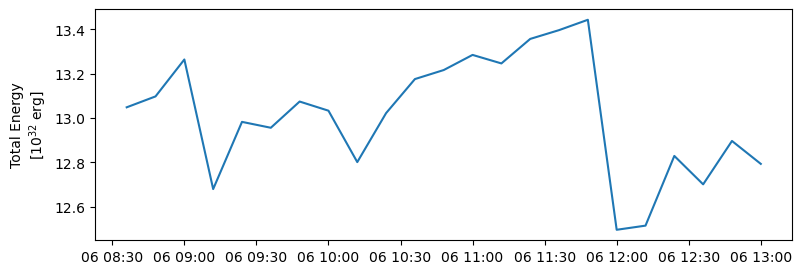

In [ ]:
plt.figure(figsize=(9, 3))
plt.plot(series_results['date'], np.array(series_results['total_energy']) * 1e-32)
plt.ylabel('Total Energy\n[$10^{32}$ erg]')
plt.show()

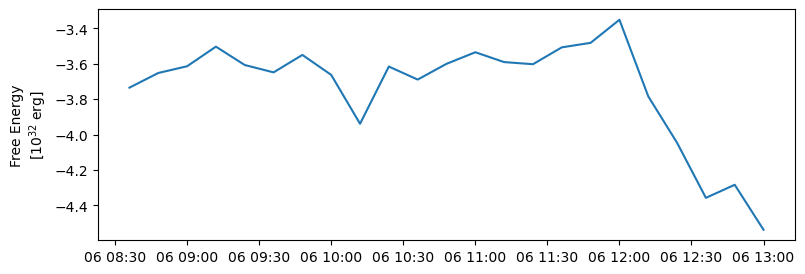

In [ ]:
plt.figure(figsize=(9, 3))
plt.plot(series_results['date'], np.array(series_results['total_free_energy']) * 1e-32)
plt.ylabel('Free Energy\n[$10^{32}$ erg]')
plt.show()

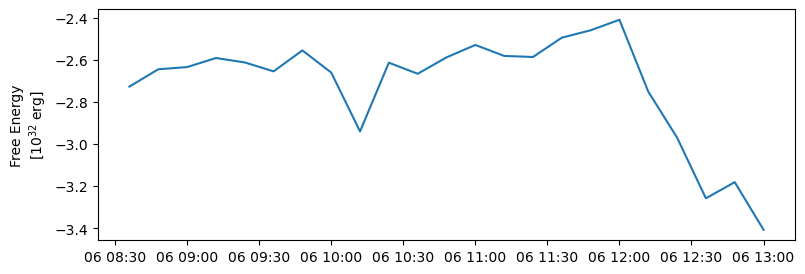

In [ ]:
plt.figure(figsize=(9, 3))
plt.plot(series_results_z_pixel['date'], np.array(series_results_z_pixel['total_free_energy']) * 1e-32)
plt.ylabel('Free Energy\n[$10^{32}$ erg]')
plt.show()

In [ ]:
from matplotlib.colors import Normalize

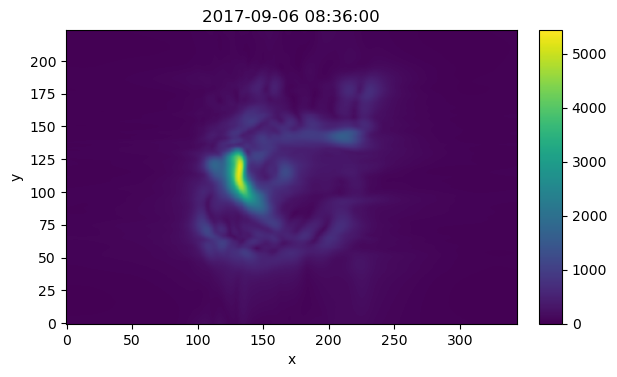

In [ ]:
fig, ax = plt.subplots()
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

ax.set_xlabel('x')
ax.set_ylabel('y')

dates = series_results['date']
j_maps = np.array(series_results['j_map'])
vmax = j_maps.max()

def update(frame_number):
    cax.cla()
    im = ax.imshow(j_maps[frame_number, ...].T, origin='lower', norm=Normalize(vmin=0, vmax=vmax), cmap='viridis')
    fig.colorbar(im, cax=cax)
    ax.set_title(dates[frame_number])

ani = animation.FuncAnimation(fig, update, frames=len(dates))
HTML(ani.to_html5_video())

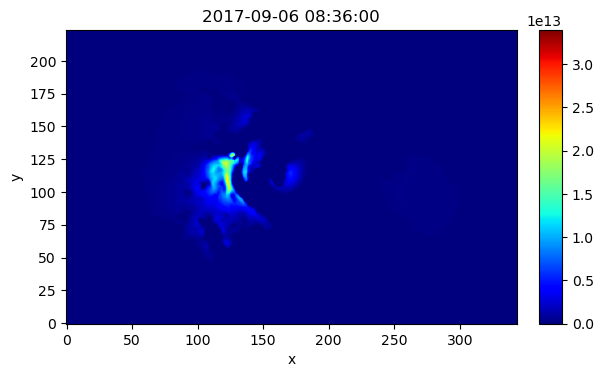

In [ ]:
fig, ax = plt.subplots()
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

ax.set_xlabel('x')
ax.set_ylabel('y')

dates = series_results['date']
free_energy_maps = np.array(series_results['free_energy_map'])
vmax = free_energy_maps.max()

def update(frame_number):
    cax.cla()
    im = ax.imshow(free_energy_maps[frame_number, ...].T, origin='lower', norm=Normalize(vmin=0, vmax=vmax), cmap='jet')
    fig.colorbar(im, cax=cax)
    ax.set_title(dates[frame_number])

ani = animation.FuncAnimation(fig, update, frames=len(dates))
HTML(ani.to_html5_video())

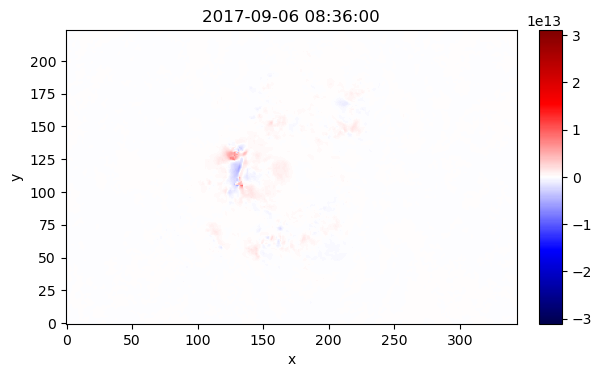

In [ ]:
fig, ax = plt.subplots()
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

ax.set_xlabel('x')
ax.set_ylabel('y')

dates = series_results['date']
free_energy_change_maps = np.gradient(np.array(series_results['free_energy_map']), axis=0)
v_min_max = np.max(np.abs(free_energy_change_maps))

def update(frame_number):
    cax.cla()
    im = ax.imshow(free_energy_change_maps[frame_number, ...].T, origin='lower', 
                   norm=Normalize(vmin=-v_min_max, vmax=v_min_max), cmap='seismic')
    fig.colorbar(im, cax=cax)
    ax.set_title(dates[frame_number])

ani = animation.FuncAnimation(fig, update, frames=len(dates))
HTML(ani.to_html5_video())

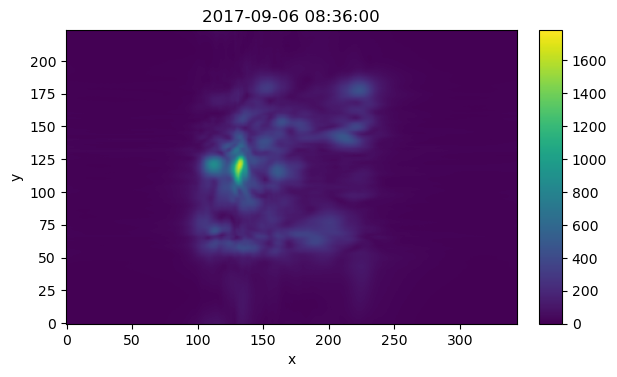

In [ ]:
fig, ax = plt.subplots()
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

ax.set_xlabel('x')
ax.set_ylabel('y')

dates = series_results['date']
laplacian_maps = np.array(series_results['laplacian_map'])
vmax = laplacian_maps.max()

def update(frame_number):
    cax.cla()
    im = ax.imshow(laplacian_maps[frame_number, ...].T, origin='lower', norm=Normalize(vmin=0, vmax=vmax), cmap='viridis')
    fig.colorbar(im, cax=cax)
    ax.set_title(dates[frame_number])

ani = animation.FuncAnimation(fig, update, frames=len(dates))
HTML(ani.to_html5_video())